In [96]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys
sys.executable

'C:\\Users\\leejd\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\python.exe'

# Utils
### - Implement

In [97]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTION_SYMBOLS = {ACTION_UP: '↑', ACTION_DOWN: '↓', ACTION_LEFT: '←', ACTION_RIGHT: '→'}

In [98]:
# 장애물을 고려하지 않고 이동 가능한 방향을 반환하는 get_available_actions 함수
def get_available_actions(state, grid_reward):
    actions = []
    x, y = state
    # 상하좌우 이동 가능 여부 확인 (장애물 여부는 체크하지 않음)
    if x > 0:  # 위로 이동 가능
        actions.append(ACTION_UP)
    if x < len(grid_reward) - 1:  # 아래로 이동 가능
        actions.append(ACTION_DOWN)
    if y > 0:  # 왼쪽으로 이동 가능
        actions.append(ACTION_LEFT)
    if y < len(grid_reward[0]) - 1:  # 오른쪽으로 이동 가능
        actions.append(ACTION_RIGHT)
    return actions

# 장애물 여부를 확인하지 않고 이동 결과를 반환하는 get_transition 함수
def get_transition(state, action, grid_reward):
    x, y = state
    next_state = state  # 기본적으로 현재 상태 유지
    
    # 가능한 방향으로 이동하거나, 불가능할 경우 현재 상태 유지
    if action == ACTION_UP:
        next_state = (x - 1, y) if x > 0 else state
    elif action == ACTION_DOWN:
        next_state = (x + 1, y) if x < grid_reward.shape[0] - 1 else state
    elif action == ACTION_LEFT:
        next_state = (x, y - 1) if y > 0 else state
    elif action == ACTION_RIGHT:
        next_state = (x, y + 1) if y < grid_reward.shape[1] - 1 else state

    reward = grid_reward[state[0], state[1]]
    return next_state, reward

# Utils
### - Given

In [99]:
def generate_grid_world(obstacles):
    grid_size = 7
    grid_reward = np.full((grid_size, grid_size), -1)

    for (x, y) in obstacles:
        grid_reward[x, y] = -100

    # Define start and end positions
    start = (0, 0)
    end = (6, 6)
    grid_reward[end[0], end[1]] = 0

    return grid_reward, start, end



def print_policy(policy,end):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ')
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            else:
                policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
    for row in policy_symbols:
        print(' '.join(row))

def visualize_map(data, title):
    plt.imshow(data, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Value')
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="Green")
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


def visualize_policy(policy, start, end, title, israndom):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ', dtype="U10")  # 기본 공백으로 초기화

    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            elif (x, y) == (start[0], start[1]):
                policy_symbols[x, y] = 'S'  # Start
            elif policy[x, y] is None:
                continue  # 장애물 위치는 표시 없음
            else:
                if isinstance(policy[x, y], list):  # 여러 방향인 경우
                    temp_policy_symbol = ''.join(ACTION_SYMBOLS[action] for action in policy[x, y])
                    policy_symbols[x, y] = temp_policy_symbol
                else:
                    policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')  # 단일 방향
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(np.arange(0, grid_size + 1, 1))
    ax.set_yticks(np.arange(0, grid_size + 1, 1))
    ax.set_yticklabels(np.arange(grid_size, -1, -1))
    ax.grid(True)

    for x in range(grid_size):
        for y in range(grid_size):
            ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                    ha='center', va='center', fontsize=10 if not israndom else 20)
            if grid[x, y] == -100:  # 장애물 처리
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='black')
                ax.add_patch(rect)
            elif (x, y) == (end[0], end[1]):  # 목표 지점 처리
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='green', alpha=0.3)
                ax.add_patch(rect)
            elif (x, y) == (start[0], start[1]):  # 시작 지점 처리
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='blue', alpha=0.3)
                ax.add_patch(rect)

    plt.title(title)
    plt.show()

# Policy initialization
### - Implement

In [100]:
# 수정된 policy_generator 함수
def policy_generator(grid_reward, israndom, isall=False):
    grid_size = grid_reward.shape[0]
    policy = np.empty((grid_size, grid_size), dtype=object)
    
    for x in range(grid_size):
        for y in range(grid_size):
            if israndom:
                policy[x, y] = np.random.choice(get_available_actions((x, y), grid_reward))  # 무작위 정책
            else:
                policy[x, y] = get_available_actions((x, y), grid_reward)  # 가능한 모든 방향을 포함
    return policy

# Policy evaluation
### - Implement

In [101]:
def policy_evaluation(grid_reward, policy, discount_factor=0.9, theta=1e-1, israndom=True):
    grid_size = grid_reward.shape[0]
    V = np.zeros((grid_size, grid_size))  # 초기 가치 함수는 모든 상태에 대해 0으로 설정
    goal_state = (grid_size - 1, grid_size - 1)  # 종료 상태 (최하단 우측)
    """필요한 함수 선언 """
    def compute_value(x, y, actions):
        """주어진 상태에서 가치 함수 계산"""
        updated_value = 0
        for action in actions:
            next_state, reward = get_transition((x, y), action, grid_reward)
            updated_value += reward + discount_factor * V[next_state]
        return updated_value / len(actions)  # 균등 확률로 평균 가치를 계산

    def update_value_if_needed(x, y):
        """현재 상태에 대해 가치 함수 업데이트"""
        if (x, y) == goal_state:  # 종료 상태는 업데이트하지 않음
            return 0, 0

        actions = [int(i) for i in str(policy[x, y])]  # 각 상태에서 가능한 행동을 리스트로 불러오기
        new_value = compute_value(x, y, actions)

        old_value = V[x, y]
        V[x, y] = new_value
        return old_value, new_value
        """필요한 함수 선언 끝"""
    while True:
        delta = 0  # 가치 함수 변화량 초기화

        # 각 상태에 대해 가치 함수 업데이트
        for x, y in np.ndindex(grid_size, grid_size):
            old_value, new_value = update_value_if_needed(x, y)
            delta = max(delta, abs(old_value - new_value))  # 변화량(delta) 업데이트

        yield V.copy()  # 각 반복 단계에서 현재 가치 함수를 반환

        # 변화량이 수렴 기준(theta) 이하로 떨어지면 종료
        if delta < theta:
            break

    return V  # 최종 수렴된 가치 함수 반환


# Policy improvement
### -Implement

In [102]:
def policy_improvement(grid_reward, V, discount_factor=0.9):
    grid_size = grid_reward.shape[0]
    new_policy = np.empty((grid_size, grid_size), dtype=object)

    for x in range(grid_size):
        for y in range(grid_size):
            # 목표 지점에서는 정책이 필요하지 않음
            if (x, y) == (6, 6):
                new_policy[x, y] = None
                continue
            
            best_action = None
            best_value = -float('inf')
            available_actions = get_available_actions((x, y), grid_reward)
            
            for action in available_actions:
                next_state, reward = get_transition((x, y), action, grid_reward)
                action_value = reward + discount_factor * V[next_state[0], next_state[1]]
                if action_value > best_value:
                    best_value = action_value
                    best_action = action

            new_policy[x, y] = best_action  # 최적 행동 저장

    return new_policy

# Policy iteration
### - Implement

In [103]:
def policy_iteration(grid, max_iterations=100, discount_factor=0.9,theta=1e-3):
    # 초기 정책을 무작위로 생성
    policy = policy_generator(grid, israndom=True)
    stable = False
    iteration = 0
    
    while not stable and iteration < max_iterations:
        iteration += 1  # 반복 횟수 증가
        
        # 정책 평가 단계: 현재 정책에 대해 가치 함수를 평가
        V = np.zeros(grid.shape)  # 상태 가치 초기화
        for V in policy_evaluation(grid, policy, discount_factor, theta, israndom=False):
            pass  # 수렴된 가치 함수 V를 사용
        
        # 0부터 10번까지의 Iteration에 대해서만 Value Function과 Policy 시각화
        if 0 <= iteration <= 10:
            visualize_map(V, f"Value Function at Iteration {iteration}")
            visualize_policy(policy, start, end, f"Policy at Iteration {iteration}", True)
        
        # 정책 개선 단계: 평가된 가치 함수 V를 바탕으로 정책을 개선
        new_policy = policy_improvement(grid, V, discount_factor)
        

        policy = new_policy  # 새롭게 개선된 정책으로 갱신
    
    
    return policy, V


# Value iteration
### - Implement

In [ ]:
def value_iteration(grid_reward: np.ndarray, discount_factor=0.9, theta=1e-1):
    # 초기 가치 함수 V와 정책을 grid_reward 크기에 맞춰 초기화
    V = np.zeros_like(grid_reward, dtype=float)
    policy = np.empty(grid_reward.shape, dtype=object)
    iteration = 0  # 반복 횟수 초기화

    while True:
        delta = 0  # 오차 초기화
        iteration += 1  # 반복 횟수 증가

        for x in range(V.shape[0]):
            for y in range(V.shape[1]):
                # 목표 지점은 정책을 정의할 필요가 없으므로 점프프
                if grid_reward[x, y] == 0:
                    policy[x, y] = None
                    continue

                max_value = -np.inf
                best_actions = []

                # 각 행동에 대한 가치를 계산
                for action in ACTIONS:
                    next_state, reward = get_transition((x, y), action, grid_reward)
                    value = reward + discount_factor * V[next_state[0], next_state[1]]
                    
                    # 최적 행동과 가치를 찾기 위해 비교
                    if value > max_value:
                        max_value = value
                        best_actions = [action]
                    elif value == max_value:
                        best_actions.append(action)
                
                # delta 업데이트
                delta = max(delta, abs(V[x, y] - max_value))

                # V[x, y] 업데이트 및 정책 저장
                V[x, y] = max_value
                policy[x, y] = best_actions if len(best_actions) > 1 else best_actions[0]

        # 0부터 10번째 반복까지의 중간 결과 시각화
        if 0 <= iteration <= 10:
            visualize_map(V, f"Value Function at Iteration {iteration}")

        # 반복 종료 조건
        if delta < theta:
            break

    return V, policy


# Initialization
### - Given

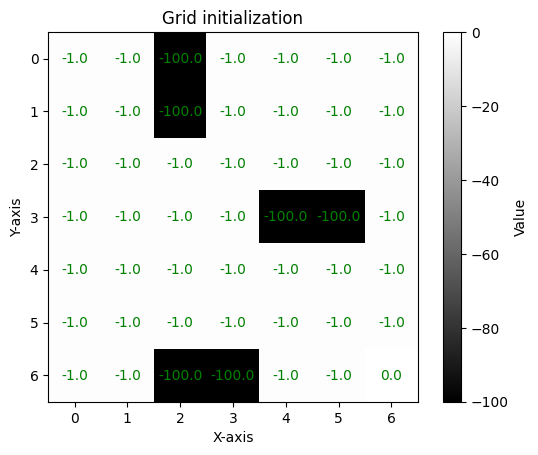

In [105]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTION_SYMBOLS = {ACTION_UP: '↑', ACTION_DOWN: '↓', ACTION_LEFT: '←', ACTION_RIGHT: '→'}

border = f"\n{'='*60}\n"
obstacles = [(0, 2), (1, 2), (3, 4), (3, 5), (6, 2), (6, 3)]
grid, start, end = generate_grid_world(obstacles)
print(border)
visualize_map(grid, "Grid initialization")
print(border)

# Show policy iteration results
### - Given

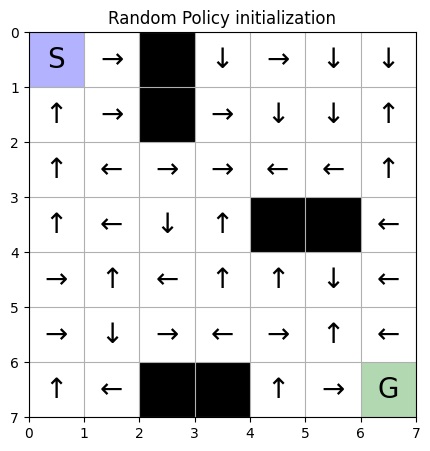

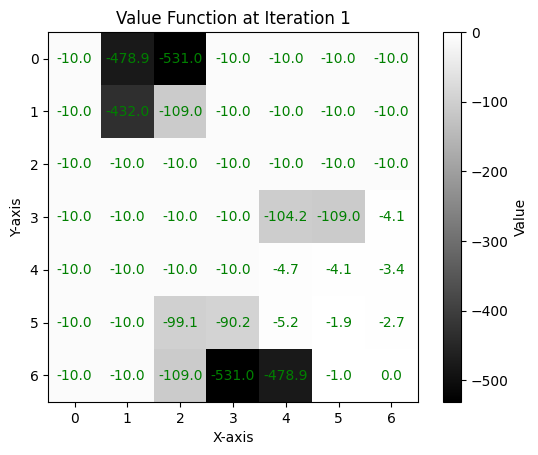

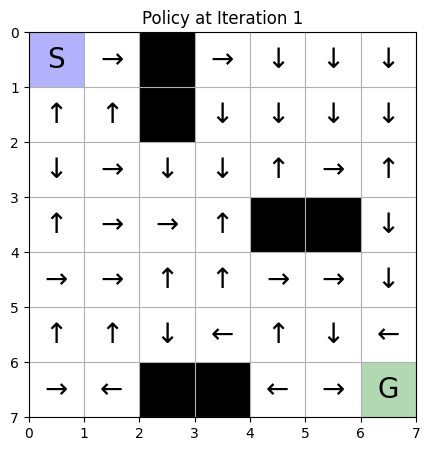

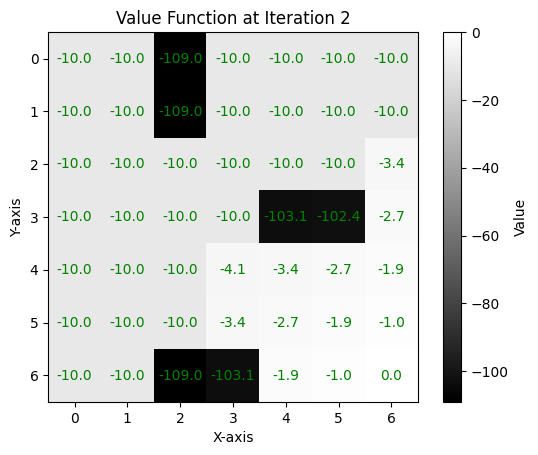

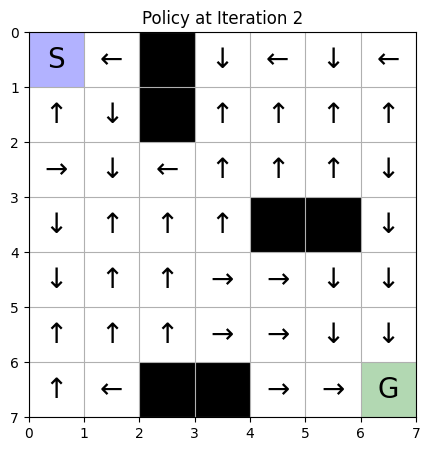

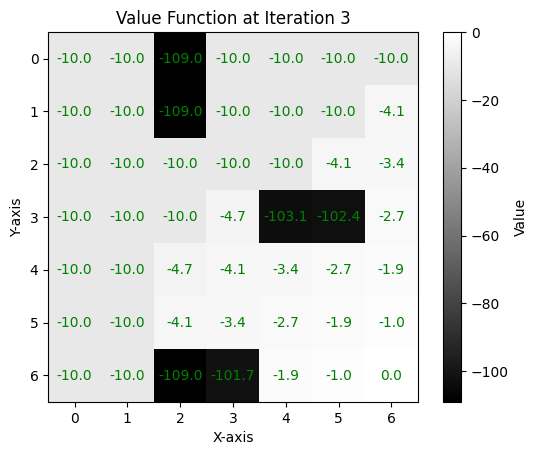

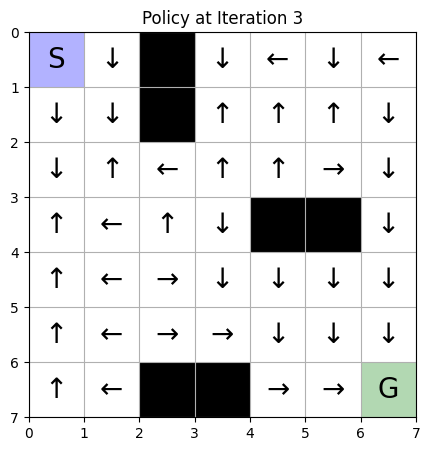

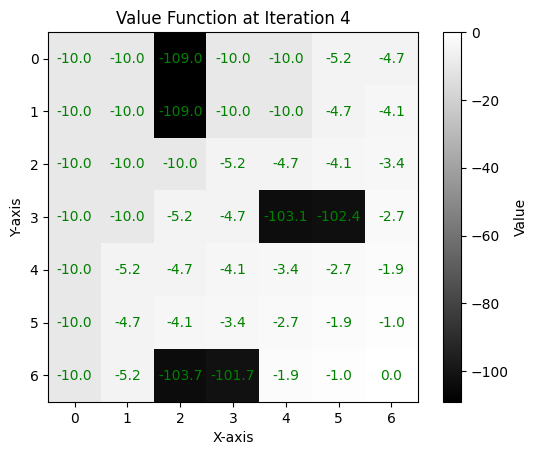

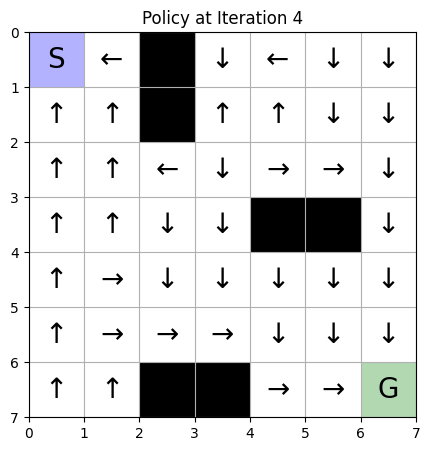

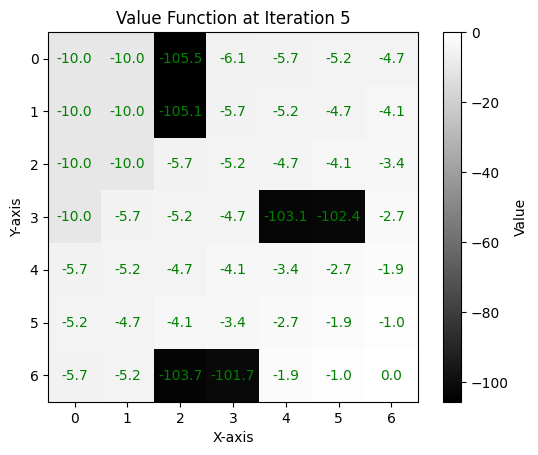

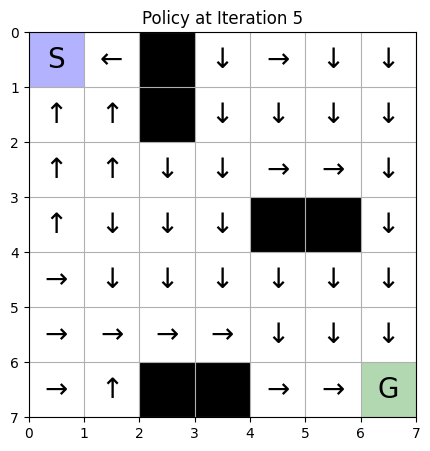

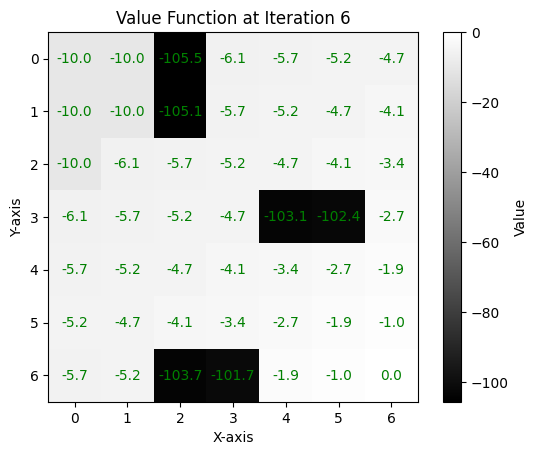

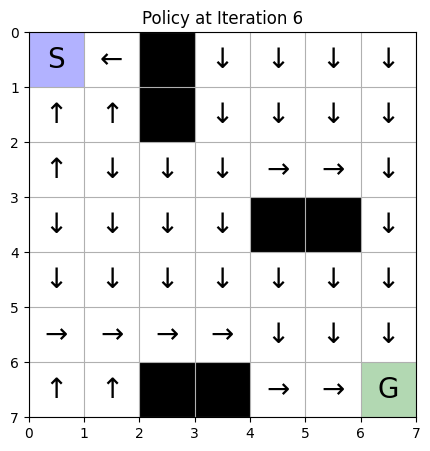

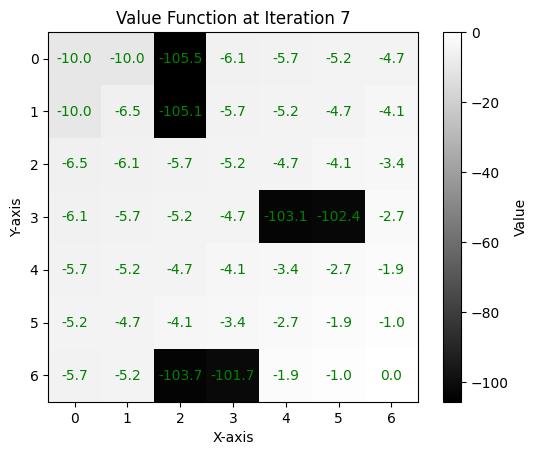

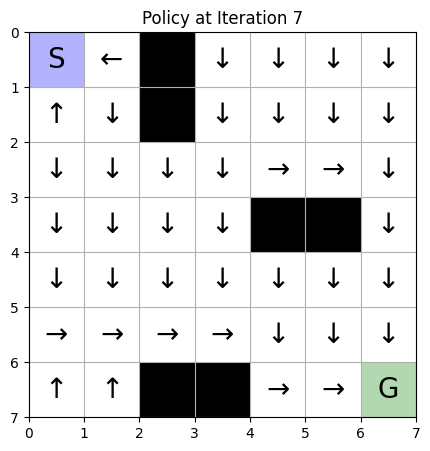

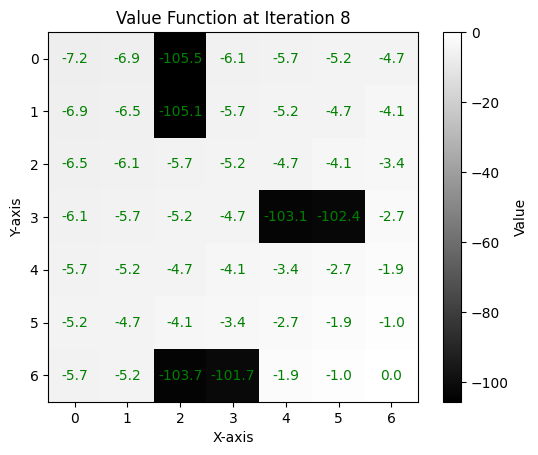

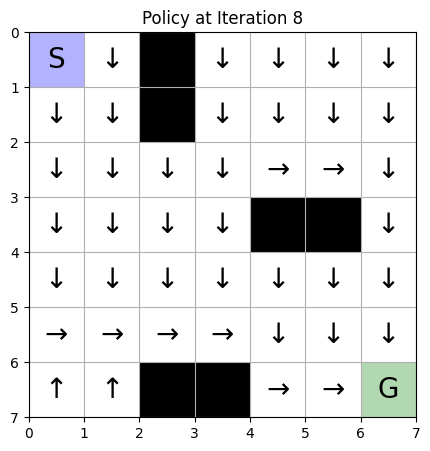

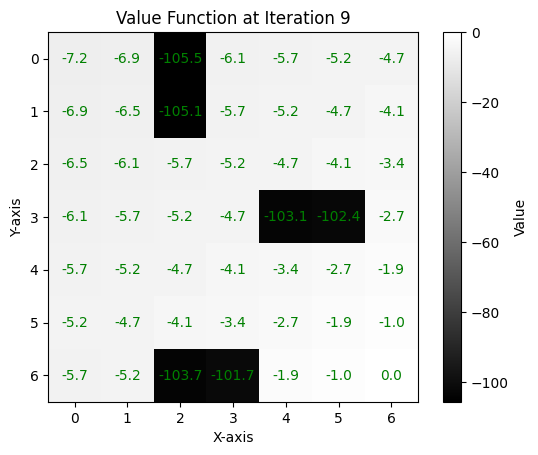

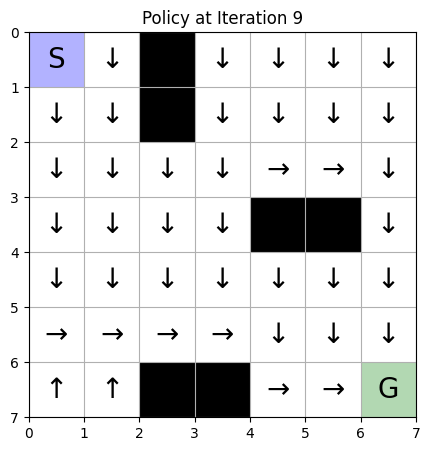

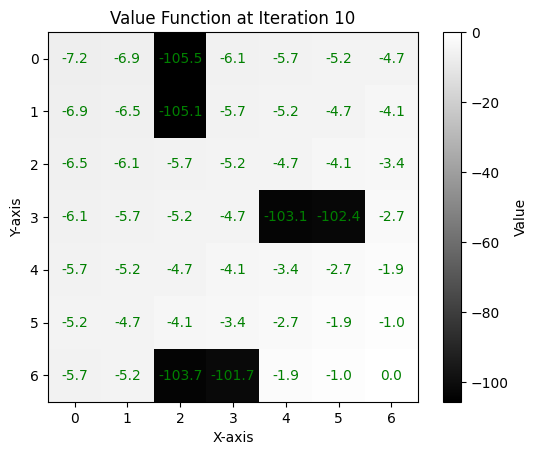

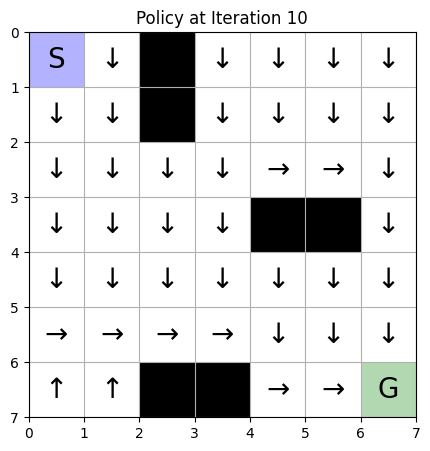

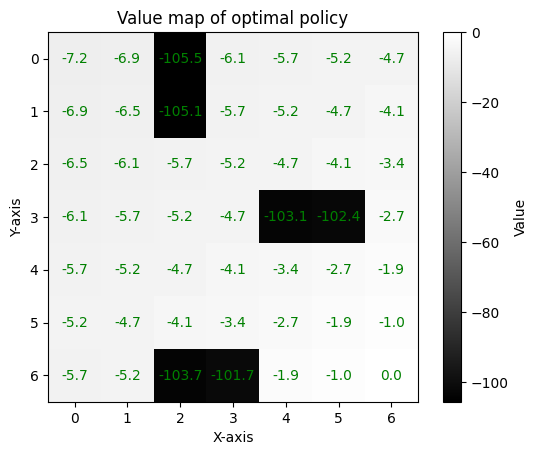

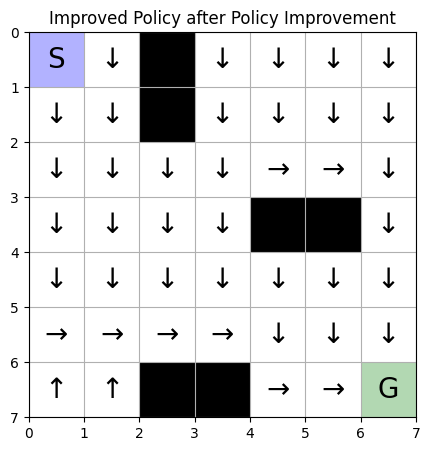

In [106]:
# Policy initialization
random_policy = policy_generator(grid, israndom=True)
visualize_policy(random_policy, start, end, "Random Policy initialization", True)

# Policy iteration
optimal_policy, optimal_value = policy_iteration(grid)
visualize_map(optimal_value, "Value map of optimal policy")
visualize_policy(optimal_policy, start, end, "Improved Policy after Policy Improvement", True)

# Show value iteration results
### - Given

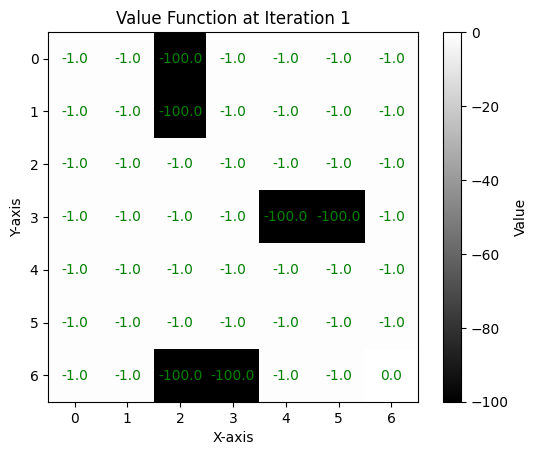

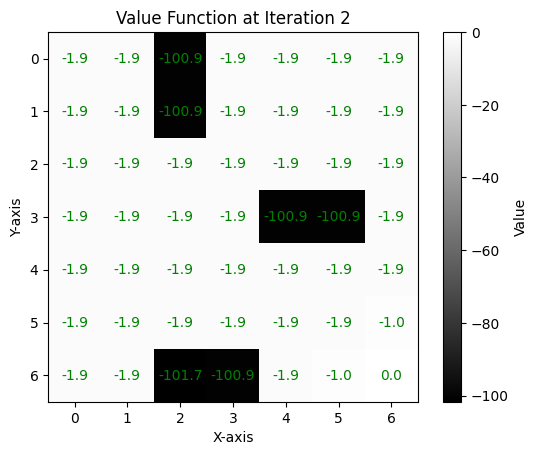

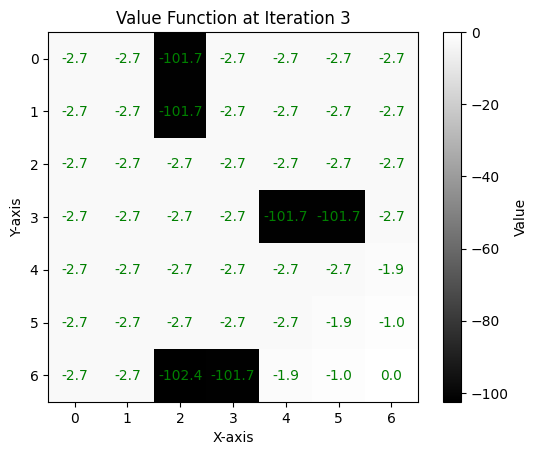

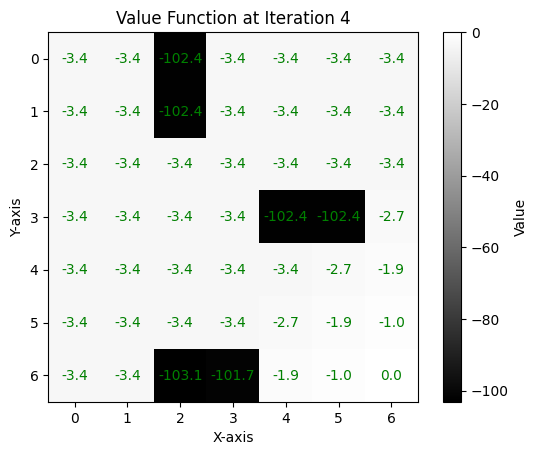

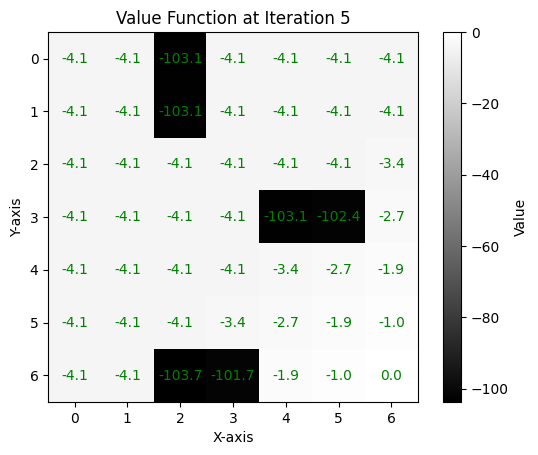

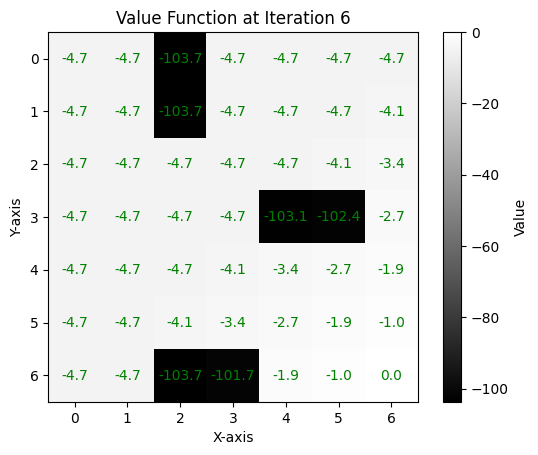

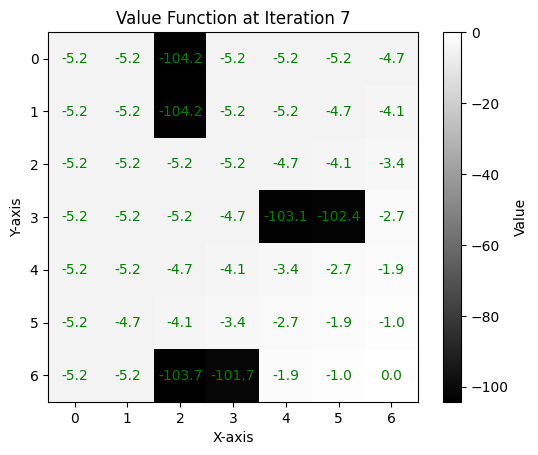

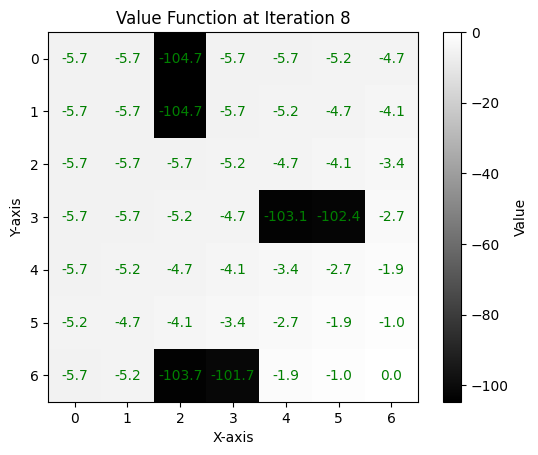

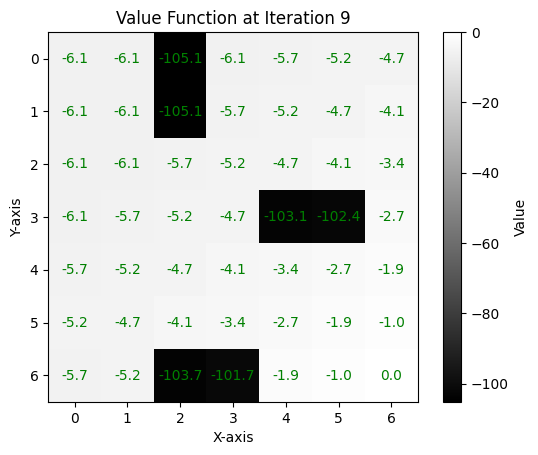

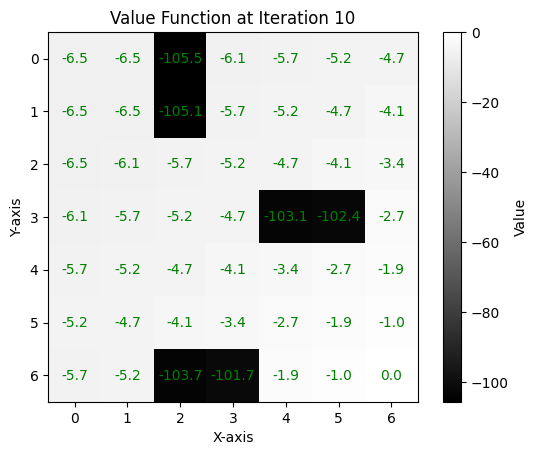

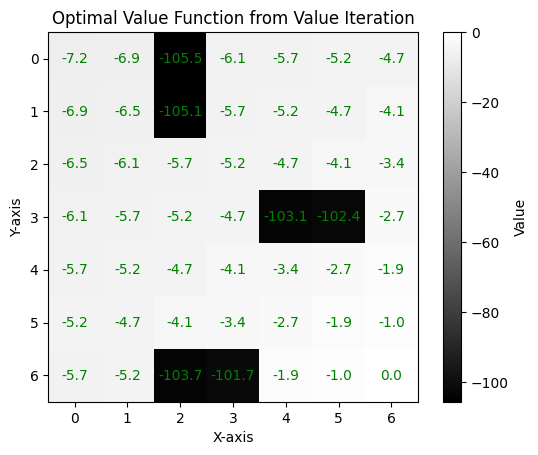

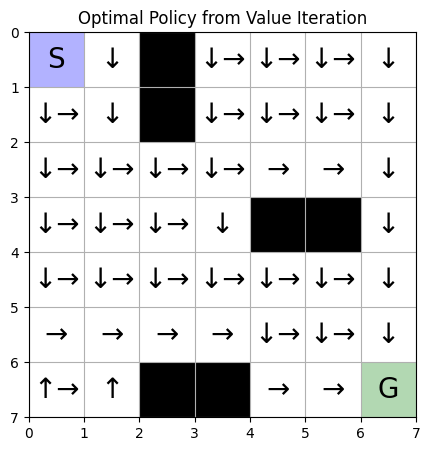

In [107]:
V_opt, optimal_policy = value_iteration(grid)
visualize_map(V_opt, "Optimal Value Function from Value Iteration")
visualize_policy(optimal_policy, start, end, "Optimal Policy from Value Iteration", True)